In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# clustering functions
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

# SARIMA model and autocorrelation plots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# SARIMA model throws lots of MLE convergence errors
import warnings
warnings.filterwarnings("ignore")

### Initialization

In [2]:
# read clean electricity data to create target variable array y
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')

# remove Davenport for now because it is missing most of June and July
elec.drop('Davenport',axis=1,inplace=True)

### Clustering analysis

The clustering algorithm calculates the distance between each point of an array with other arrays like it. Here, there is an array for each building: a 24-entry array giving the average electricity demand for each hour of the day. For the algorithm to work, these arrays must be on the same scale, between 0 and 1.

In [3]:
# calculate the average day-of-week and hour-of-day profiles, then apply sklearn minmaxscaler
scaler = MinMaxScaler()

hour_of_day = elec.groupby(elec.index.hour).sum()
day_of_week = elec.groupby(elec.index.dayofweek).sum()
hour_of_day_norm = pd.DataFrame(scaler.fit_transform(hour_of_day.values),columns=hour_of_day.columns)
day_of_week_norm = pd.DataFrame(scaler.fit_transform(day_of_week.values),columns=day_of_week.columns)

The cophenet clustering score is 0.851


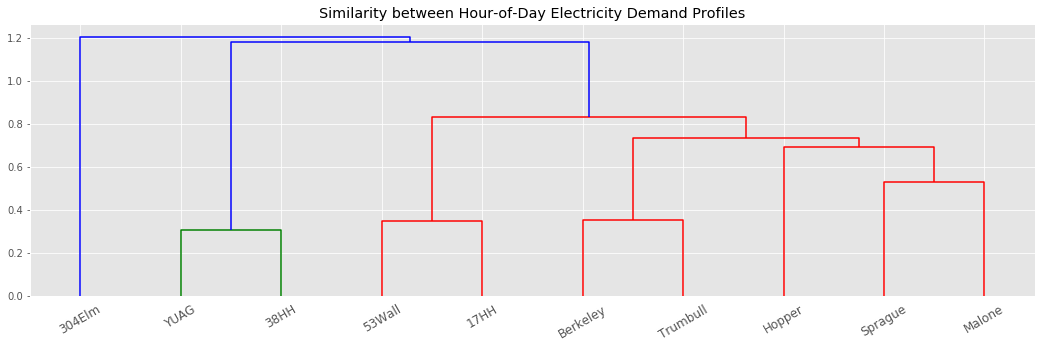

In [4]:
# create the hour-of-day linkage matrix hod_linkage
hod_linkage = linkage(hour_of_day_norm.values.T,'average')
labels = hour_of_day_norm.columns

# plot the dendrogram
plt.figure(figsize=(18, 5))
dendrogram(hod_linkage,orientation='top',labels=labels,distance_sort='descending',)
plt.xticks(rotation=30)
plt.title('Similarity between Hour-of-Day Electricity Demand Profiles')

# calculate the cophenetic correlation coefficient, a clustering evaluation metric (>0.75 is good)
clustering_score, coph_dists = cophenet(hod_linkage, pdist(hour_of_day_norm.values.T))
print('The cophenet clustering score is {}'.format(np.round(clustering_score,3)))

In [5]:
hod_clustering = fcluster(hod_linkage,3,criterion='maxclust')

cluster1_buildings = [elec.columns[k] for k in range(len(elec.columns)) if hod_clustering[k] == 1]
cluster2_buildings = [elec.columns[k] for k in range(len(elec.columns)) if hod_clustering[k] == 2]
cluster3_buildings = [elec.columns[k] for k in range(len(elec.columns)) if hod_clustering[k] == 3]

cluster1 = pd.Series(elec[cluster1_buildings].sum(axis=1))
cluster2 = pd.Series(elec[cluster2_buildings].sum(axis=1))
cluster3 = pd.Series(elec[cluster3_buildings].sum(axis=1))

aggregate = pd.Series(elec.sum(axis=1))
actual = pd.Series(elec.sum(axis=1))

### Transformation of median-shifting features

Many predictive models require stationary data. Electricity demand data is never stationary, because it includes seasonal (daily, weekly, yearly) effects as well as trend (steady/exponential increase) effects.

The following cells make the data stationary by calculating and then removing the hour-of-week (weekend vs weekday) and week-of-year (spring break vs class in session) effects.

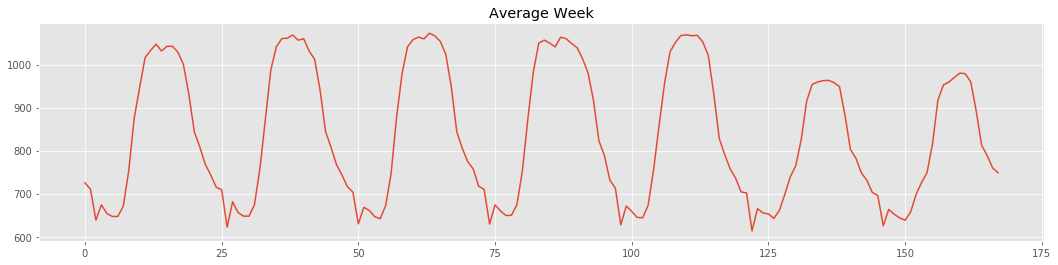

In [6]:
# calculate hour-of-week and week-of-year averages to isolate weekend, holiday median-shifting
hourofweekarray, hourofweek = range(168),range(1,168) # 2018 starts on a thursday
while len(hourofweek) < 10000: hourofweek = np.append(hourofweek,hourofweekarray)
hourofweek = hourofweek[:4991]

# create a stationary version of each cluster. could write a function here
avg_week = cluster1.groupby(hourofweek).mean()
cluster1_week_transformer = np.vectorize(avg_week.to_dict().get)(hourofweek)
avg_year = cluster1.groupby(cluster1.index.weekofyear).mean()
cluster1_year_transformer = cluster1.index.weekofyear.map(avg_year)
cluster1_stationary = cluster1/cluster1_week_transformer/cluster1_year_transformer

avg_week = cluster2.groupby(hourofweek).mean()
cluster2_week_transformer = np.vectorize(avg_week.to_dict().get)(hourofweek)
avg_year = cluster2.groupby(cluster2.index.weekofyear).mean()
cluster2_year_transformer = cluster2.index.weekofyear.map(avg_year)
cluster2_stationary = cluster2/cluster2_week_transformer/cluster2_year_transformer

avg_week = cluster3.groupby(hourofweek).mean()
cluster3_week_transformer = np.vectorize(avg_week.to_dict().get)(hourofweek)
avg_year = cluster3.groupby(cluster3.index.weekofyear).mean()
cluster3_year_transformer = cluster3.index.weekofyear.map(avg_year)
cluster3_stationary = cluster3/cluster3_week_transformer/cluster3_year_transformer

avg_week = aggregate.groupby(hourofweek).mean()
aggregate_week_transformer = np.vectorize(avg_week.to_dict().get)(hourofweek)
avg_year = aggregate.groupby(aggregate.index.weekofyear).mean()
aggregate_year_transformer = aggregate.index.weekofyear.map(avg_year)
aggregate_stationary = aggregate/aggregate_week_transformer/aggregate_year_transformer

# plot an average week for diagnostics
avg_week.plot(figsize=(18,4),title="Average Week")

As you can see in the "stationary" plot below, the transformations used do not accurately remove the effects of holidays shorter than one week, like the 4th of July, Thanksgiving, Christmas. To improve the model, these could be hard-coded or identified by clustering with weekends over multiple years of data.

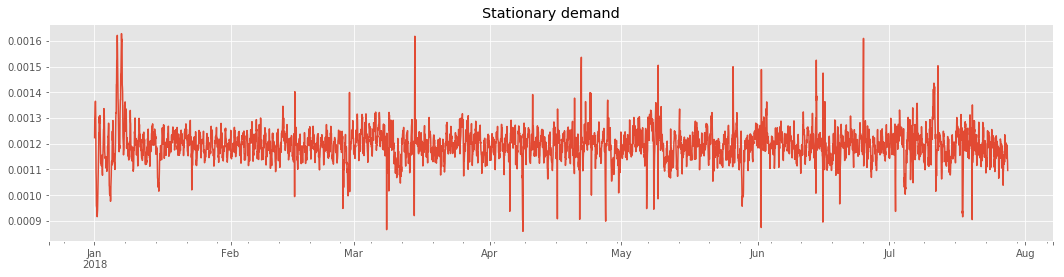

In [7]:
aggregate_stationary.plot(figsize=(18,4),title='Stationary demand')

### Predictive Modeling: Seasonal ARIMA

The SARIMA (seasonal autoregressive integrated moving average) model has four parameters: P,D,Q, and m. P,D, and Q are the *seasonal* autoregressive, differencing, and moving average terms, while m is the period. For the demand data, m should be 24. SARIMA also supports trend terms, but there is no trend in this data, so they will not be used.

The cells below train and test SARIMA models for several days in of the training set, starting on February 1st. The MAPE of each daily forecast is stored in the mapes DataFrame, and the predictions are stored in the y_forecast Series.

In [8]:
# dataframe containing data to be tested
data = pd.DataFrame({'cluster1':cluster1_stationary,
                     'cluster2':cluster2_stationary,
                     'cluster3':cluster3_stationary,
                     'aggregate':aggregate_stationary})

# model parameters
num_days = 10
start = '2018-02-01 09:00:00'
trend_params = (0,0,0)
seasonal_params = (1,0,1,24)

In [9]:
# initialize some useful objects for the modeling loop
start_times = pd.date_range(start=start,freq='D',periods=num_days)
forecasts = data.copy(deep=True)

for k in data.columns:
    for i in range(num_days):
        y_train = data[k].loc[data.index < start_times[i]].values
        # train and fit the model
        model = SARIMAX(y_train, order=trend_params,seasonal_order=seasonal_params,enforce_stationarity=False)
        model_fit = model.fit(disp=0,maxiter=200)
        # make and store a 39-step-forward forecast
        forecast = model_fit.forecast(steps=39)[15:]
        forecasts[k].loc[start_times[i]+pd.Timedelta(hours=15):start_times[i]+pd.Timedelta(hours=38)]=forecast

The next cell creates a results dataframe with forecasts for the individual cluster forecasts and the aggregate forecast. It also includes the actual data for easy comparison, then plots the results.

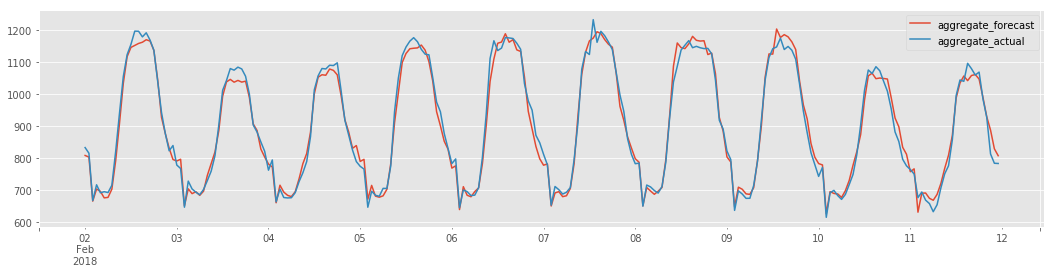

In [11]:
results = pd.DataFrame(index = forecasts.index)

# reverse the transformations, add actual columns
results['cluster1_forecast'] = forecasts['cluster1']*cluster1_year_transformer*cluster1_week_transformer
results['cluster2_forecast'] = forecasts['cluster2']*cluster2_year_transformer*cluster2_week_transformer
results['cluster3_forecast'] = forecasts['cluster3']*cluster3_year_transformer*cluster3_week_transformer
results['cluster_sum_forecast'] = results['cluster1_forecast'] + results['cluster2_forecast'] + results['cluster3_forecast']
results['aggregate_forecast'] = forecasts['aggregate']*aggregate_year_transformer*aggregate_week_transformer
results['cluster1_actual'] = cluster1.values
results['cluster2_actual'] = cluster2.values
results['cluster3_actual'] = cluster3.values
results['aggregate_actual'] = actual.values

results = results[start_times[0]+pd.Timedelta(hours=15):start_times[num_days-1]+pd.Timedelta(hours=38)]

results[['aggregate_forecast','aggregate_actual']].plot(figsize=(18,4))

In [12]:
# define helper mape function, print the mape of individual clusters, the cluster sum, and agg forecasts
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

print('Average MAPE for {} day-ahead forecasts:\n'.format(num_days))
print('Cluster 1:     {}'.format(np.round(mape(results.cluster1_actual,results.cluster1_forecast),3)))
print('Cluster 2:     {}'.format(np.round(mape(results.cluster2_actual,results.cluster2_forecast),3)))
print('Cluster 3:     {}'.format(np.round(mape(results.cluster3_actual,results.cluster3_forecast),3)))
print('Cluster Sum:   {}'.format(np.round(mape(results.aggregate_actual,results.cluster_sum_forecast),3)))
print('Aggregate:     {}'.format(np.round(mape(results.aggregate_actual,results.aggregate_forecast),3)))

Average MAPE for 10 day-ahead forecasts:

Cluster 1:     4.152
Cluster 2:     2.207
Cluster 3:     4.827
Cluster Sum:   2.109
Aggregate:     2.087


## Plots for export

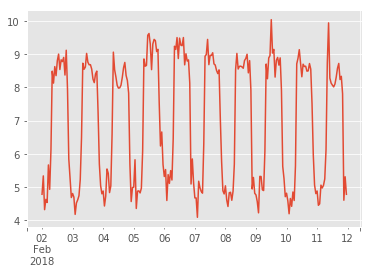

In [19]:
results['cluster3_forecast'].plot()